In [0]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen

import gzip
import itertools
import string
import wordcloud
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pylab as pl

from collections import Counter
from sklearn import svm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

%matplotlib inline

In [3]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Cell_Phones_and_Accessories_5.json.gz

--2020-05-01 02:28:50--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Cell_Phones_and_Accessories_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169071325 (161M) [application/octet-stream]
Saving to: ‘Cell_Phones_and_Accessories_5.json.gz’

Cell_Phones_and_Acc 100%[===================>] 161.24M  11.0MB/s    in 16s     

2020-05-01 02:29:06 (10.2 MB/s) - ‘Cell_Phones_and_Accessories_5.json.gz’ saved [169071325/169071325]



In [4]:
data = []
with gzip.open('Cell_Phones_and_Accessories_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

1128437
{'overall': 5.0, 'verified': True, 'reviewTime': '08 4, 2014', 'reviewerID': 'A24E3SXTC62LJI', 'asin': '7508492919', 'style': {'Color:': ' Bling'}, 'reviewerName': 'Claudia Valdivia', 'reviewText': 'Looks even better in person. Be careful to not drop your phone so often because the rhinestones will fall off (duh). More of a decorative case than it is protective, but I will say that it fits perfectly and securely on my phone. Overall, very pleased with this purchase.', 'summary': "Can't stop won't stop looking at it", 'unixReviewTime': 1407110400}


In [5]:
# convert list into pandas dataframe
df = pd.DataFrame.from_dict(data)

print(len(df))

1128437


In [0]:
#df2 = df
#df2['vote'] = df2['vote'].fillna('0')

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128437 entries, 0 to 1128436
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   overall         1128437 non-null  float64
 1   verified        1128437 non-null  bool   
 2   reviewTime      1128437 non-null  object 
 3   reviewerID      1128437 non-null  object 
 4   asin            1128437 non-null  object 
 5   style           605241 non-null   object 
 6   reviewerName    1128302 non-null  object 
 7   reviewText      1127672 non-null  object 
 8   summary         1127920 non-null  object 
 9   unixReviewTime  1128437 non-null  int64  
 10  vote            1128437 non-null  object 
 11  image           27107 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 95.8+ MB


In [0]:
df.groupby(['asin']).size().sort_values(ascending=False).reset_index(name='count')

,asin,count
0,B00VH88CJ0,1684
1,B005NF5NTK,1634
2,B00X5RV14Y,1514
3,B00P7N0320,1513
4,B019PV2I3G,1508
...,...,...
48181,B000YUE340,1
48182,B00172L5JU,1
48183,B0014TAFPG,1
48184,B0010S8S3C,1


# Section - EDA and Preprocessing

In [0]:
print('Dataset size: {:,} words'.format(len(df)))

Dataset size: 1,128,437 words


In [0]:
df[:3]

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"08 4, 2014",A24E3SXTC62LJI,7508492919,{'Color:': ' Bling'},Claudia Valdivia,Looks even better in person. Be careful to not...,Can't stop won't stop looking at it,1407110400,NaN,NaN
1,5.0,True,"02 12, 2014",A269FLZCB4GIPV,7508492919,NaN,sarah ponce,When you don't want to spend a whole lot of ca...,1,1392163200,NaN,NaN
2,3.0,True,"02 8, 2014",AB6CHQWHZW4TV,7508492919,NaN,Kai,"so the case came on time, i love the design. I...",Its okay,1391817600,NaN,NaN


Reformat $\underline{datetime}$ from raw form.

In [0]:
df["reviewTime"] = pd.to_datetime(df["reviewTime"])

Rearrange the left-to-right by relevance

In [0]:
df = df[['asin', 'summary', 'reviewText', 'overall', 'reviewerID', 'reviewerName', 'reviewTime',
      'unixReviewTime']]
df.head(3)

,asin,summary,reviewText,overall,reviewerID,reviewerName,reviewTime,unixReviewTime
0,7508492919,Can't stop won't stop looking at it,Looks even better in person. Be careful to not...,5.0,A24E3SXTC62LJI,Claudia Valdivia,2014-08-04,1407110400
1,7508492919,1,When you don't want to spend a whole lot of ca...,5.0,A269FLZCB4GIPV,sarah ponce,2014-02-12,1392163200
2,7508492919,Its okay,"so the case came on time, i love the design. I...",3.0,AB6CHQWHZW4TV,Kai,2014-02-08,1391817600


## Number of Reviews by Unique Products [asin]


In [0]:
products = df['overall'].groupby(df['asin']).count()
print("Number of Unique Products in the Cell Phones & Accessories Category = {}".format(products.count()))

Number of Unique Products in the Cell Phones & Accessories Category = 48186


Top 20 Reviewed Products

In [0]:
sorted_products = products.sort_values(ascending=False)

print("Top 20 Reviewed Products:\n")
print(sorted_products[:20], end='\n\n')
print('Most Reviewed Product, B001HBHNHE - has {} reviews.'.format(products.max()))

Top 20 Reviewed Products:

asin
B00VH88CJ0    1684
B005NF5NTK    1634
B00X5RV14Y    1514
B00P7N0320    1513
B019PV2I3G    1508
B018JW3EOY    1506
B00G7UY3EG    1378
B00MQSMDYU    1340
B00M51DDT2    1267
B00QN1T6NM    1228
B00IGISUTG    1119
B0092KJ9BU    1065
B00D856NOG    1043
B00BT8L2MW    1028
B00AANQLRI    1023
B00UCZGS6S    1008
B00UH3L82Y    1008
B014EB532U    1002
B00MXWFUQC     978
B00M6QODH2     977
Name: overall, dtype: int64

Most Reviewed Product, B001HBHNHE - has 1684 reviews.


The top 1 reviewed product is "Anker 24W Dual USB Car Charger, PowerDrive 2 for iPhone X / 8/7 / 6s / Plus, iPad Pro/Air 2 / Mini, Note 5/4, LG, Nexus, HTC, and More" 

Bottom 20 Reviewed Products

In [0]:
print("Bottom 20 Reviewed Products:\n")
print(sorted_products[48166:], end='\n\n')
print('Least Reviewed Product (Sorted), B003Z6HUZE - has {} reviews.'.format(products.min()))

Bottom 20 Reviewed Products:

asin
B0017O94ZK    1
B000X1IR56    1
B0013N5QMA    1
B00165ABSY    1
B0014Z2KBW    1
B0012FY7TW    1
B0013LKXEI    1
B0012IZ4JG    1
B0013FBFFU    1
B001654GD0    1
B000XEBXT0    1
B00T66ICN6    1
B000Y96H1I    1
B000Y9KLVU    1
B0013CBM3S    1
B000YUE340    1
B00172L5JU    1
B0014TAFPG    1
B0010S8S3C    1
B0016569I0    1
Name: overall, dtype: int64

Least Reviewed Product (Sorted), B003Z6HUZE - has 1 reviews.


WE can check B0017O94ZK is the least popular

## Reviews

In [0]:
reviews = df['reviewText']
reviews.count()

1127672

In [0]:
df.['reviwerName'] = pd.as

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128437 entries, 0 to 1128436
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   asin            1128437 non-null  object        
 1   summary         1127920 non-null  object        
 2   reviewText      1127672 non-null  object        
 3   overall         1128437 non-null  float64       
 4   reviewerID      1128437 non-null  object        
 5   reviewerName    1128302 non-null  object        
 6   reviewTime      1128437 non-null  datetime64[ns]
 7   unixReviewTime  1128437 non-null  int64         
 8   TEXT            1127672 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 77.5+ MB


In [0]:
df['TEXT'] = df['reviewText'].str.lower()

import string 
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

df["TEXT"] = df['TEXT'].apply(remove_punctuations)

from nltk.corpus import stopwords
stop = stopwords.words('english')

df['TEXT'] = df['TEXT'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

import re

df.TEXT = df.TEXT.str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')

df["TEXT_split"] = df.TEXT.str.split()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


AttributeError: ignored

In [0]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
def tokenize(text):
    tokenized = word_tokenize(text)
    no_punc = []
    for review in tokenized:
        line = "".join(char for char in review if char not in string.punctuation)
        no_punc.append(line)
    tokens = lemmatize(no_punc)
    return tokens


def lemmatize(tokens):
    lmtzr = WordNetLemmatizer()
    lemma = [lmtzr.lemmatize(t) for t in tokens]
    return lemma

In [0]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
reviews = reviews.apply(lambda x: tokenize(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


TypeError: ignored

## Influencers' influence

In [6]:
# import the dataset
influencers = pd.read_csv('/content/influencers.csv')
influencers['reviewTime'] = pd.to_datetime(influencers['reviewTime'], format ='%Y-%m-%d')
influencers.head(3)

,reviewTime,overall,verified,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,image,avgVote,influencer,Year,Month,Weekday
0,2016-07-14,4.0,1,A22QN0P5ERNOKR,B01F9N5QXI,Paul M.,"<div id=""video-block-R1K03IBUILYEB0"" class=""a-...","The only thing ""cheap"" about this budget smart...",1468454400,1,782.0,1,2016,7,3
1,2015-08-21,5.0,0,AQJ824C2JST96,B00X5RV14Y,Gladius,Anker PowerCore 20100 Review by a Frequent Fl...,Anker PowerCore 20100 Review by a Frequent Fl...,1440115200,0,653.0,1,2015,8,4
2,2016-02-05,5.0,1,A1BDNTBJ0JWXSL,B019O8YWXE,Wilfred,OVERVIEW\nThe Huawei Honor 5x is the first of ...,The first real budget phone thats worth the money,1454630400,1,530.0,1,2016,2,4


In [7]:
# whether there are more than 1 influencers in one product
inf = influencers.loc[influencers['influencer'] == 1]
inf2 = inf.groupby('asin').count().reset_index()
inf2 = inf2[['asin','reviewerID']]
mask = inf2['reviewerID'] == 1
inf3 = inf2[mask] 
inf3

,asin,reviewerID
0,B0002SYC5O,1
1,B000FYU4SO,1
2,B001DETCUG,1
3,B001UBB9GM,1
4,B0027FFZEW,1
...,...,...
404,B01H2W0576,1
405,B01H3V07EW,1
406,B01H3WHNEI,1
407,B01H477CJS,1


In [8]:
# choose 341 unique asin
inf_inner = pd.merge(inf,inf3,on='asin',how='right')
inf_inner

,reviewTime,overall,verified,reviewerID_x,asin,reviewerName,reviewText,summary,unixReviewTime,image,avgVote,influencer,Year,Month,Weekday,reviewerID_y
0,2016-07-14,4.0,1,A22QN0P5ERNOKR,B01F9N5QXI,Paul M.,"<div id=""video-block-R1K03IBUILYEB0"" class=""a-...","The only thing ""cheap"" about this budget smart...",1468454400,1,782.0,1,2016,7,3,1
1,2015-12-28,3.0,0,AT63Q5FKZEJ4I,B0176HQ1O8,Jason S.,"Okay, first of all, I will leave the feel and ...",Good well rounded product.,1451260800,1,449.0,1,2015,12,0,1
2,2015-04-30,5.0,1,A284QS51P9P9V1,B00UVSNVHA,TechnicianPrime,*INSTALL NOTE: No instructions included. Simp...,It's EXACTLY how you'd expect it to be and doe...,1430352000,1,395.0,1,2015,4,3,1
3,2017-01-25,2.0,1,A25GROL6KJV3QG,B01B1DTASC,Benson Leung,Benson here again doing another USB Type-C acc...,AUKEY PB-Y8 has serious Type-C spec violations...,1485302400,1,329.0,1,2017,1,2,1
4,2017-10-04,5.0,1,A30NSBS0QMT9KD,B01G1XUCA2,Savvy Online Consumer,"This 22,000mAh battery is a bit heavy but feel...",Heavy but Powerful!,1507075200,1,323.0,1,2017,10,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,2014-10-17,5.0,1,A3PXICZ0O2H3VO,B00HY3HT5A,John Davidson,This is awesome. I previously had the CM4 cas...,Worth it - absolutely.,1413504000,1,48.0,1,2014,10,4,1
337,2017-04-27,5.0,1,A2W021AUTMYXFQ,B01D2U6BWU,Amazon Customer,I've had this for a couple months now & love i...,Beautiful & surprisingly sturdy,1493251200,1,48.0,1,2017,4,3,1
338,2014-07-02,5.0,0,A136QHBYMSF3QA,B00KHY09BE,Ken Hopson,Upgraded from an S3 to an S5 Active. The guy a...,"Amazing phone, but be aware of the difference ...",1404259200,0,48.0,1,2014,7,2,1
339,2016-06-07,5.0,1,A3IHLJ7KSE9DGS,B00YD53FHS,Lala J.,I was scared of receiving this phone because o...,... of receiving this phone because of all of ...,1465257600,0,48.0,1,2016,6,1,1


In [9]:
# set index for the review date of 341 unique influncers
reviewtime = inf_inner['reviewTime'].to_frame()
reviewtime['asin'] = inf_inner['asin']
reviewtime['label'] = reviewtime.index
reviewtime

,reviewTime,asin,label
0,2016-07-14,B01F9N5QXI,0
1,2015-12-28,B0176HQ1O8,1
2,2015-04-30,B00UVSNVHA,2
3,2017-01-25,B01B1DTASC,3
4,2017-10-04,B01G1XUCA2,4
...,...,...,...
336,2014-10-17,B00HY3HT5A,336
337,2017-04-27,B01D2U6BWU,337
338,2014-07-02,B00KHY09BE,338
339,2016-06-07,B00YD53FHS,339


In [10]:
# Extract the review time
# Count the reviewText
# Filter by asin
df['reviewTime'] = pd.to_datetime(df['reviewTime'], format ='%m %d, %Y')
timecount_draft = df[['asin','reviewTime','reviewText']].groupby(['asin','reviewTime']).count()
timecount_draft = timecount_draft.reset_index()
timecount_draft

,asin,reviewTime,reviewText
0,7508492919,2012-07-17,1
1,7508492919,2012-07-27,1
2,7508492919,2012-10-08,2
3,7508492919,2012-10-25,1
4,7508492919,2012-10-31,1
...,...,...,...
1031188,B01HJH9IN6,2016-11-23,1
1031189,B01HJH9IN6,2016-12-13,1
1031190,B01HJH9IN6,2017-01-02,1
1031191,B01HJH9IN6,2017-01-05,1


In [11]:
# Combine the timecount and inf3 - create a dataset that contains certain productID
timecount = pd.merge(timecount_draft,inf3,on = 'asin',how = 'right')
timecount = timecount[['asin','reviewTime','reviewText']]
timecount

,asin,reviewTime,reviewText
0,B0002SYC5O,2014-01-14,1
1,B0002SYC5O,2014-03-08,1
2,B0002SYC5O,2014-03-13,1
3,B0002SYC5O,2014-04-09,1
4,B0002SYC5O,2014-04-12,1
...,...,...,...
44976,B01H76NIAS,2018-08-29,1
44977,B01H76NIAS,2018-09-05,1
44978,B01H76NIAS,2018-09-12,1
44979,B01H76NIAS,2018-09-25,1


Now we can use reviewtime and timecount datasets to calculate the number of comments during specific time for each product

In [12]:
# count the number of comments
import datetime
rows = []
for i in range(0,len(reviewtime),1):
  mask1 = timecount['asin'] ==  timecount['asin'][i]
  timecount_asin = timecount[mask1]
  mask2 = (timecount_asin['reviewTime'] > str(reviewtime['reviewTime'][i]-datetime.timedelta(days=60))) & (timecount_asin['reviewTime'] <= str(reviewtime['reviewTime'][i]))
  rows.append([reviewtime['reviewTime'][i],reviewtime['asin'][i],timecount_asin.loc[mask2].reviewText.sum()])
  i = i + 1
  before = pd.DataFrame(rows, columns = ['Time','Asin' , 'Number of comments 60 days before']) 
before

,Time,Asin,Number of comments 60 days before
0,2016-07-14,B01F9N5QXI,4
1,2015-12-28,B0176HQ1O8,11
2,2015-04-30,B00UVSNVHA,8
3,2017-01-25,B01B1DTASC,10
4,2017-10-04,B01G1XUCA2,2
...,...,...,...
336,2014-10-17,B00HY3HT5A,6
337,2017-04-27,B01D2U6BWU,0
338,2014-07-02,B00KHY09BE,3
339,2016-06-07,B00YD53FHS,1


In [13]:
# count the number of comments
import datetime
rows = []
for i in range(0,len(reviewtime),1):
  mask1 = timecount['asin'] ==  timecount['asin'][i]
  timecount_asin = timecount[mask1]
  mask2 = (timecount_asin['reviewTime'] > str(reviewtime['reviewTime'][i])) & (timecount_asin['reviewTime'] <= str(reviewtime['reviewTime'][i]+ datetime.timedelta(days=60)))
  rows.append([reviewtime['reviewTime'][i],reviewtime['asin'][i],timecount_asin.loc[mask2].reviewText.sum()])
  i = i + 1
  after = pd.DataFrame(rows, columns = ['Time' ,'Asin', 'Number of comments 60 days after']) 
after

,Time,Asin,Number of comments 60 days after
0,2016-07-14,B01F9N5QXI,6
1,2015-12-28,B0176HQ1O8,9
2,2015-04-30,B00UVSNVHA,15
3,2017-01-25,B01B1DTASC,4
4,2017-10-04,B01G1XUCA2,0
...,...,...,...
336,2014-10-17,B00HY3HT5A,4
337,2017-04-27,B01D2U6BWU,0
338,2014-07-02,B00KHY09BE,5
339,2016-06-07,B00YD53FHS,0


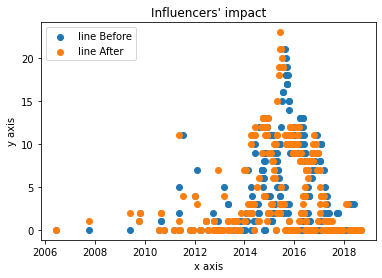

In [14]:
import matplotlib.pyplot as plt
 
x  = before['Time']
y1 = before['Number of comments 60 days before']
y2 = after['Number of comments 60 days after']
plt.scatter(x, y1, label="line Before")
plt.scatter(x, y2, label="line After")
plt.plot()

plt.xlabel("x axis")
plt.ylabel("y axis")
plt.title("Influencers' impact")
plt.legend()
plt.show()

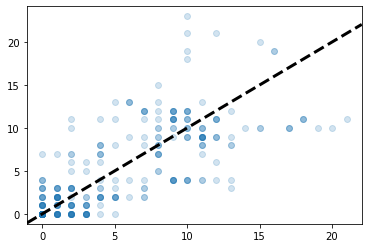

In [15]:
import matplotlib.pyplot as plt
y1 = before['Number of comments 60 days before']
y2 = after['Number of comments 60 days after']
plt.scatter(y1,y2,alpha = 0.2)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

In [25]:
# Summarize the number of comments dataset
before2 = before[['Asin' , 'Number of comments 60 days before']]
comments = pd.merge(before2, after, on = "Asin")
comments['Diff'] = comments['Number of comments 60 days after'] - comments['Number of comments 60 days before']
comments.head(5)

,Asin,Number of comments 60 days before,Time,Number of comments 60 days after,Diff
0,B01F9N5QXI,4,2016-07-14,6,2
1,B0176HQ1O8,11,2015-12-28,9,-2
2,B00UVSNVHA,8,2015-04-30,15,7
3,B01B1DTASC,10,2017-01-25,4,-6
4,B01G1XUCA2,2,2017-10-04,0,-2


In [26]:
comments.Diff.describe()

count    341.000000
mean      -0.181818
std        3.275905
min      -10.000000
25%       -2.000000
50%        0.000000
75%        1.000000
max       13.000000
Name: Diff, dtype: float64

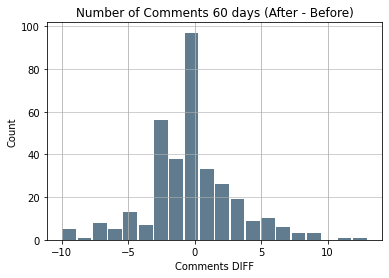

In [36]:
import numpy as np
import matplotlib.pyplot as plt
diff = comments['Diff']
diff.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Number of Comments 60 days (After - Before)')
plt.xlabel('Comments DIFF')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)